In [1]:
import os
import json
import time
import pickle
import random 
import networkx as nx

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
def plot_graph(g):
    plt.clf()
    plt.figure(3,figsize=(10,6))
    nx.draw_kamada_kawai(g, with_labels = True)

In [3]:
# computing max peel value for the input graph
def getMaxPeelValueVis(G, name="new"):
    
    G_copy = G.copy()

    iteration = 0
    peel_value = 0
    degrees = [val for (node, val) in G_copy.degree()]

    plt.figure(figsize = (35, 45))

    while len(G_copy.nodes) > 0:
        iteration += 1
        fringe = G_copy.nodes
        fringe_degrees = [val for (node, val) in G_copy.degree()]

        # pick the vertices of minimum degree 
        min_degree = min(fringe_degrees)
        peel_value = max(peel_value, min_degree)
        min_degree_nodes = [node for index, node in enumerate(fringe) if G_copy.degree(node) == min_degree]

        plt.subplot(920+iteration)
        plt.title("-----Iteration :" + str(iteration) +
                  "------\nMin degree = " + str(min_degree) +
                  " \nMin degree Indices = {" + str(min_degree_nodes) +
                  "} \nPeel Value = " + str(peel_value))

        nx.draw_kamada_kawai(G_copy, with_labels = True)

        # remove the min degree vertices from fringe
        for node in min_degree_nodes:
            G_copy.remove_node(node)
    
    plt.savefig("peelvalue/PeelValue-"+ name + str(iteration) +".png", format="PNG")
    plt.clf()
    return peel_value

In [4]:
def getWaveVis(G, S0, P, name="1"):
    G_copy = G.copy()
    
    iteration = 0
    print("S 0 : ", S0)
    
    S = []
    edges_within_frag = []
    edge_fragments = []

    plt.figure(figsize = (20, 10))
    plt.set_cmap("viridis")
    
    G_wave = nx.Graph()
    while len(S0) > 0:
        iteration += 1
        S.append(S0)
        
        S1 = set()
        b_edges = []
        f_edges = []
        G_wave.add_nodes_from(S0)
        
        # Remove the Frag of S0 in G
        for node in S0:
            
            # E(G[S0])
            for node1 in S0:
                if (node1 in G_copy and 
                    node1 != node and 
                    (node1, node) in G_copy.edges() and
                    (node1, node) not in f_edges and
                    (node, node1) not in f_edges):
                    
                    G_copy.remove_edge(node, node1)
                    f_edges.append((node, node1))
            
            # BE(G[S0])
            for neighbor in E[node]:
                if node in G_copy and neighbor in G_copy:
                    
                    if neighbor not in S0:
                        S1.add(neighbor)
                        b_edges.append((node, neighbor))
                    
                    if (node, neighbor) in G_copy.edges():
                        G_copy.remove_edge(node, neighbor)

                    if(G_copy.degree(node) == 0):
                        G_copy.remove_node(node)

                    if(G_copy.degree(neighbor) == 0):
                        G_copy.remove_node(neighbor)
                        
                    elif(G_copy.degree(neighbor) > P):
                        S1.discard(neighbor)
        
            
        print("Boundary edges:", b_edges)       
        print("S", iteration, ":", S1)
        S0 = S1
        edges_within_frag.append(f_edges)
        if len(b_edges) > 0 and len(S0) > 0:
            edge_fragments.append(b_edges + f_edges)
            G_wave.add_edges_from(b_edges + f_edges)
            
    
    # Plot Wave
    if(len(G_wave.nodes()) > 0):
        plot_wave(name, G_wave, S, edges_within_frag, iteration)
    else:
        print("No nodes to plot in graph wave.")
        
        
    # Plot leftover G
    if(len(G_copy.nodes()) > 0):
        plot_graph(G_copy)
    else:
        print("No nodes to plot in leftover graph.")
    
    return [S, edge_fragments, G_wave, G_copy]


def plot_wave(name, G_wave, S, edges_within_frag, iteration):
    plt.title("-----Wave :" + name + "------\n")
    
    pos = nx.kamada_kawai_layout(G_wave, scale=0.5)
    viridis = cm.get_cmap('viridis', 12)
    for index in range(len(S)):
        #print("Ps: ", pos)
        new_pos = {key: pos[key] + [0, index*2] for key in pos}
        #print("Ps new: ", new_pos)
        
        edge_list = edges_within_frag[index] if index < len(edges_within_frag) else None
        new_color_map = [viridis(index * 0.3)] * len(S[index])
        
        nx.draw_networkx(G_wave,
                         new_pos,
                         with_labels = True,
                         font_color="white",
                         set_cmap="viridis",
                         nodelist=S[index],
                         edgelist=edge_list,
                         node_color=new_color_map)
    
    plt.savefig("waves/Wave-"+ name + str(iteration) +".png", format="PNG")

In [5]:
def getGraphWithPeelValue(G, peelValue) : 
    G_core = G.copy()
    while True :
        for d in list(G_core.degree()) :
            if d[1] < peelValue :
                G_core.remove_node(d[0])
        if sorted(G_core.degree, key = lambda x: x[1])[0][1] >= peelValue : 
            return G_core

In [6]:
# computing max peel value for the input graph without visualization
def getMaxPeelValue(G):
    
    G_copy = G.copy()

    iteration = 0
    peel_value = 0
    degrees = [val for (node, val) in G_copy.degree()]

    while len(G_copy.nodes) > 0:
        iteration += 1
        fringe = G_copy.nodes
        fringe_degrees = [val for (node, val) in G_copy.degree()]

        # pick the vertices of minimum degree 
        min_degree = min(fringe_degrees)
        peel_value = max(peel_value, min_degree)
        min_degree_nodes = [node for index, node in enumerate(fringe) if G_copy.degree(node) == min_degree]

        # remove the min degree vertices from fringe
        for node in min_degree_nodes:
            G_copy.remove_node(node)

    return peel_value

In [7]:
# Seed set generation for graph waves
def getRandomVerticesWithPeelValue(G, n, P) :
    node_list = set()
    
    if len(G.nodes()) == 0 : # if there is no nodes left
        return []
    
    v = [] # possible vertices 
    for d in list(G.degree()) :
        if d[1] <= P :
            v.append(d[0])
            
    if len(v) <= n : # if the number of nodes left is equal or less than n, return all satisfied nodes
        return v
        
    while True : # randomly pick n nodes
        node_list.add(random.choice(v))
        if len(node_list) == n :
            return list(node_list)

In [8]:
# getWave without visualization
def getWave2(G, S0, P):
    G_copy = G.copy()
    
    S = []
    edges_within_frag = []
    edge_fragments = []
    
    G_wave = nx.Graph()
    while len(S0) > 0:
        S.append(list(S0))
        
        S1 = set()
        b_edges = []
        f_edges = []
        G_wave.add_nodes_from(S0)
        
        # Remove the Frag of S0 in G
        for node in S0:
            
            # E(G[S0])
            for node1 in S0:
                if (node1 in G_copy and 
                    node1 != node and 
                    (node1, node) in G_copy.edges() and
                    (node1, node) not in f_edges and
                    (node, node1) not in f_edges):
                    
                    G_copy.remove_edge(node, node1)
                    f_edges.append((node, node1))
            
            # BE(G[S0])
            for neighbor in G.neighbors(node):
                if node in G_copy and neighbor in G_copy:
                    
                    if neighbor not in S0:
                        S1.add(neighbor)
                        b_edges.append((node, neighbor))
                    
                    if (node, neighbor) in G_copy.edges():
                        G_copy.remove_edge(node, neighbor)

                    if(G_copy.degree(node) == 0):
                        G_copy.remove_node(node)

                    if(G_copy.degree(neighbor) == 0):
                        G_copy.remove_node(neighbor)
                        
                    elif(G_copy.degree(neighbor) > P):
                        S1.discard(neighbor)
                        
            
            # remove independent vertices
            if node in G_copy:
                G_copy.remove_node(node)
        
        # print("Wave: ", S0, " : ", S1, "\n--------------")
        S0 = S1
        
        edges_within_frag.append(f_edges)
        if len(b_edges) > 0 and len(S0) > 0:
            edge_fragments.append(b_edges + f_edges)
            G_wave.add_edges_from(b_edges + f_edges)

    return [G_wave, G_copy, S]

In [9]:
# getWave2(G,  [8, 13, 16, 19, 21], 4)

In [10]:
def getBuilding(G, P) :
    G_copy = G.copy()
    building = []
    
    counter_key = 1
    while True :
        S0 = getRandomVerticesWithPeelValue(G_copy, 5, P)
        
        if len(S0) == 0: 
            break
        
        wave, leftover_G, fragments = getWave2(G_copy, S0, P)
        # print("Building: ", wave.nodes(), " : ",leftover_G.nodes(), " : ", fragments, "\n--------------")
        if len(wave.nodes()) == 0 or len(fragments) == 0 : 
            break
        
        building.append({"nodes": list(wave.nodes()), "edges": list(wave.edges()), "fragments": fragments}) # add edges into building
        counter_key += 1
        
        G_copy = leftover_G
    
    return [building, G_copy]

In [11]:
# getBuilding(G, 4)

In [12]:
def getCity(G) :
    city = []
    G_copy = G.copy()
    
    while True :
        if G_copy.number_of_nodes() == 0 :
            break
        
        peelValue = getMaxPeelValue(G_copy)
        building, leftover_g = getBuilding(G_copy, peelValue)
        
        city.append(building)
        # print("City: ", city, "\n\n---------------")
        
        G_copy = leftover_g
    
    return city

In [13]:
# getCity(G)

In [14]:
input_folder = "/common/home/milky-way/temp/"

output_text_folder = "/common/home/milky-way/new_graph_cities/cities/h"
output_image_folder = "/common/home/milky-way/new_graph_cities/graphs/h"

def save_graph(g, filename):
    
    print("Saving image "+ filename + " ...")
    fig = plt.figure(figsize=(15, 15))
    
    ax = fig.add_subplot(111)
    
    nx.draw_kamada_kawai(g, with_labels = False, node_size=50,
                         node_shape='*', node_color="gold", edge_color='crimson',
                         alpha=1, cmap=cm.get_cmap("Wistia", 10))

    plt.savefig(output_image_folder + filename + ".png", format="PNG", transparent=True)
    #facecolor="#0c055a", edgecolor='none')
    plt.clf()
    print("Saved image: " + output_image_folder + filename + ".png")


def save_city_as_file(city, filename):
    print("Saving file "+ filename + " ...")
    with open(output_text_folder + filename + ".txt", 'w') as file:
         json.dump(city, file)
    
    print("Saved JSON: " + output_text_folder + filename + ".txt\n\n")


def build_star_tile_city(u, v, stars_tile_batch):
        star_u = int(u[1])
        star_v = int(v[1])

        if(not stars_tile_batch.has_node(star_u)):
            stars_tile_batch.add_node(star_u, info=u)

        if(not stars_tile_batch.has_node(star_v)):
            stars_tile_batch.add_node(star_v, info=v)

        if(not stars_tile_batch.has_edge(star_u, star_v)):
            stars_tile_batch.add_edge(star_u, star_v)
            
            
def processStar(from_batch_filename):
    print("Processing: ", from_batch_filename)
    
    with open(input_folder + from_batch_filename) as f:
                stars_tile_batch = nx.Graph()
                
                for s in f:
                    u, v = [list(float(i) for i in el.strip('[]').split(', ')) for el in s.strip('()\n').split('], [')]
                    build_star_tile_city(u, v, stars_tile_batch)

                    
                
                star_tile_number = str(list(stars_tile_batch.nodes())[0])[: 3]
                
                
                    
                filename = star_tile_number + "_errored" 
                save_graph(stars_tile_batch, filename)
                
                cityJSON = {}
                cityJSON["data"] = getCity(stars_tile_batch)
                cityJSON["input_file"] = from_batch_filename
                
                
                save_city_as_file(cityJSON, filename)
              
                
def processAllStarTiles(folderpath):
    all_batch_files = os.listdir(folderpath)
    all_batch_files = sorted(all_batch_files)[: 1094]

    star_tile_counter = {}
    star_tile_number = None
    
    
    for from_batch_filename in all_batch_files :
        try :
            with open(input_folder + from_batch_filename) as f:
                stars_tile_batch = nx.Graph()
                print("Processing: ", from_batch_filename)
                
                for s in f:
                    u, v = [list(float(i) for i in el.strip('[]').split(', ')) for el in s.strip('()\n').split('], [')]
                    build_star_tile_city(u, v, stars_tile_batch)

                    
                counter = 1
                star_tile_number = str(list(stars_tile_batch.nodes())[0])[: 3]
#                 print(star_tile_counter)
                if star_tile_number in star_tile_counter:
                    counter = star_tile_counter[star_tile_number] + 1
                    star_tile_counter[star_tile_number] = counter
                else:
                    star_tile_counter[star_tile_number] = counter
                    
                filename = star_tile_number + "_" + str(counter)
                
#                 print(filename)
#                 print(star_tile_counter)
                
#                 time.sleep(10)
                save_graph(stars_tile_batch, filename)
                
                
                
                cityJSON = {}
                cityJSON["data"] = getCity(stars_tile_batch)
                cityJSON["input_file"] = from_batch_filename
                
                
                save_city_as_file(cityJSON, filename)
        
        except Exception as e:
            print("Got exception: ", e.with_traceback())

        finally:
            save_city_as_file(star_tile_counter, "Day10_Harshini")


Processing:  2020-12-12 04:58:34.txt
Saving image 201_1 ...
Saved image: /common/home/milky-way/new_graph_cities/graphs/h201_1.png
Saving file 201_1 ...
Saved JSON: /common/home/milky-way/new_graph_cities/cities/h201_1.txt


Saving file Day10_Harshini ...
Saved JSON: /common/home/milky-way/new_graph_cities/cities/hDay10_Harshini.txt


Processing:  2020-12-12 04:58:35.txt
Saving image 201_2 ...
Saved image: /common/home/milky-way/new_graph_cities/graphs/h201_2.png
Saving file 201_2 ...
Saved JSON: /common/home/milky-way/new_graph_cities/cities/h201_2.txt


Saving file Day10_Harshini ...
Saved JSON: /common/home/milky-way/new_graph_cities/cities/hDay10_Harshini.txt


Processing:  2020-12-12 04:58:36.txt
Saving image 201_3 ...
Saved image: /common/home/milky-way/new_graph_cities/graphs/h201_3.png
Saving file 201_3 ...
Saved JSON: /common/home/milky-way/new_graph_cities/cities/h201_3.txt


Saving file Day10_Harshini ...
Saved JSON: /common/home/milky-way/new_graph_cities/cities/hDay10_Hars

<ipython-input-14-e9e939b70424>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15, 15))


Saved image: /common/home/milky-way/new_graph_cities/graphs/h201_21.png
Saving file 201_21 ...
Saved JSON: /common/home/milky-way/new_graph_cities/cities/h201_21.txt


Saving file Day10_Harshini ...
Saved JSON: /common/home/milky-way/new_graph_cities/cities/hDay10_Harshini.txt


Processing:  2020-12-12 04:58:55.txt
Saving image 201_22 ...
Saved image: /common/home/milky-way/new_graph_cities/graphs/h201_22.png
Saving file 201_22 ...
Saved JSON: /common/home/milky-way/new_graph_cities/cities/h201_22.txt


Saving file Day10_Harshini ...
Saved JSON: /common/home/milky-way/new_graph_cities/cities/hDay10_Harshini.txt


Processing:  2020-12-12 04:58:56.txt
Saving image 201_23 ...
Saved image: /common/home/milky-way/new_graph_cities/graphs/h201_23.png
Saving file 201_23 ...
Saved JSON: /common/home/milky-way/new_graph_cities/cities/h201_23.txt


Saving file Day10_Harshini ...
Saved JSON: /common/home/milky-way/new_graph_cities/cities/hDay10_Harshini.txt


Processing:  2020-12-12 04:58:57.txt
S

KeyboardInterrupt: 

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

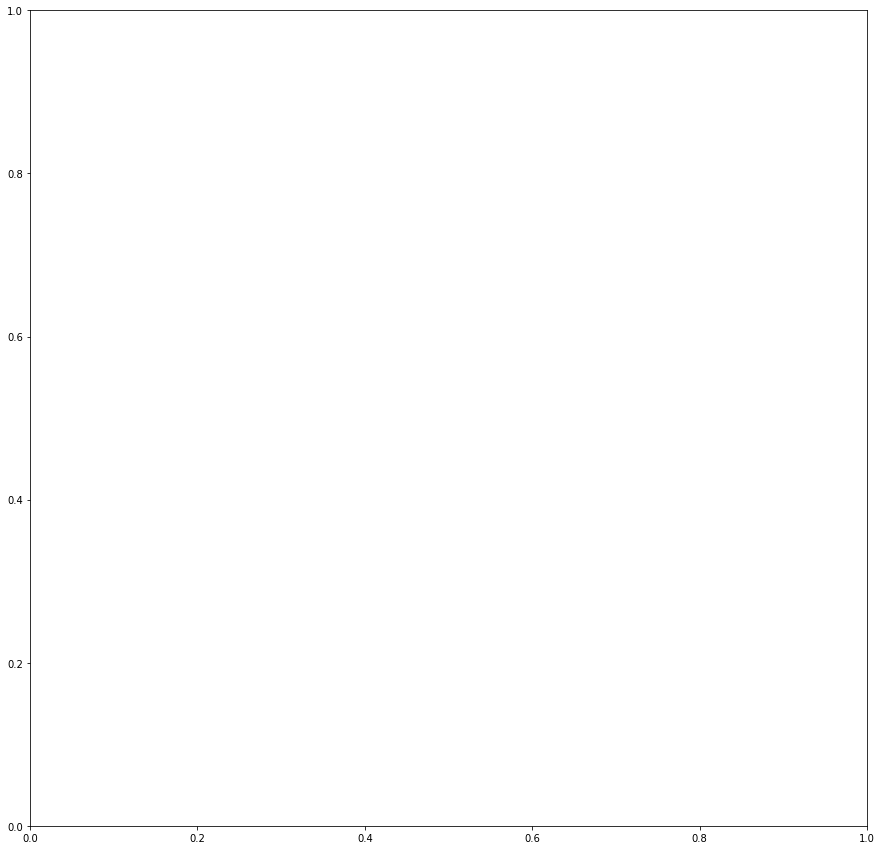

In [15]:
processAllStarTiles(input_folder)
#processStar("2020-12-12 04:58:34.txt")